In [1]:
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import time
import sys 
import seaborn as sns
from sklearn.metrics import f1_score, recall_score
from tensorflow.keras.layers import AveragePooling2D
import cv2
import re
import pandas as pd
from utils import *

sys.path.append("./models/GPA")
from useful_functions import *
sys.path.append("./models/robust-pca-master/")

In [2]:
dataset_name = "pedestrians"
result_path = f"./dataset/results/{dataset_name}"
img_path = f"./dataset/baseline/{dataset_name}/"
print(result_path, img_path)

./dataset/results/pedestrians ./dataset/baseline/pedestrians/


In [3]:
# Ground Truth Files
gt_files = glob.glob(img_path + "groundtruth/*png")
gt_files.sort()

# Raw Image Failes
raw_files = glob.glob(img_path + "input/*jpg")
raw_files.sort()

print(len(gt_files), len(raw_files))

1099 1099


In [4]:
def assert_same_gtraw(name1, name2):
    name1 = re.findall(r"gt.+\.png", name1)[0]
    index1 = re.findall("\d+", name1)[0]
    name2 = re.findall(r"in.+\.jpg", name2.split('/')[-1])[0]
    index2 = re.findall("\d+", name2)[0]
    assert index1 == index2

In [5]:
# Example Ground Truth
i = 950
gt_img = Image.open(gt_files[i])
gt_img = np.array(gt_img).astype(np.int32) / 255.0
gt_img = (gt_img > 0.5) * 1.0
gt_img.shape

(240, 360)

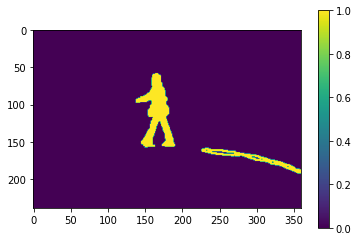

In [6]:
plt.imshow(gt_img)
plt.colorbar()

In [7]:
# Example Raw Image
raw_img = Image.open(raw_files[i])
raw_img = np.array(raw_img).astype(np.int32) / 255.0

In [8]:
p, q = raw_img.shape[0:2]

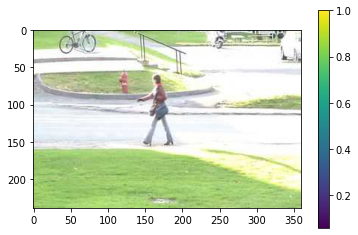

In [9]:
plt.imshow(raw_img)
plt.colorbar()

# R-PCA

In [63]:
import scipy.io
mat = scipy.io.loadmat('/mnt/MineSafe-2024/dataset/Hall.mat')

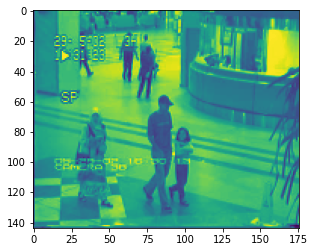

In [75]:
data = mat['Data']
plt.imshow(data[:, :, 0])
p, q, d = data.shape

In [76]:
D = np.zeros((d, p * q))

for k in range(d):
    raw_img = data[:, :, k]
    raw_vec = raw_img.ravel()
    D[k] = raw_vec

In [78]:
# i = 900                         # starting index
# window = 20                    # window
# D = np.zeros((window, p*q))     # each row is an image vectorization
# for k in range(window):
#     raw_img = load_img_np(raw_files[i+k])
#     raw_vec = raw_img.ravel()
#     D[k] = raw_vec

In [79]:
# from RobustPCA.spcp import StablePCP

# # spcp = StablePCP()
# # spcp.fit(M)
# # L = spcp.get_low_rank()
# # S = spcp.get_sparse()

In [80]:
# from RobustPCA.rpca import RobustPCA

# t1 = time.time()
# rpca = RobustPCA(tol = 1, max_iter=1000, use_fbpca=True) # max_rank=100, 
# rpca.fit(D)
# t2 = time.time()
# L = rpca.get_low_rank()
# S = rpca.get_sparse()

In [81]:
from r_pca import R_pca

In [101]:
t1 = time.time()
# use R_pca to estimate the degraded data as L + S, where L is low rank, and S is sparse
rpca = R_pca(D)
L, S = rpca.fit(max_iter=100, iter_print=1)
t2 = time.time()
print(t2 - t1)

iteration: 1, error: 10.399802635073076
iteration: 2, error: 3.2800436381372804
iteration: 3, error: 3.221313276995324
iteration: 4, error: 3.072707350676101
iteration: 5, error: 2.9827148011793008
iteration: 6, error: 2.8436909345535204
iteration: 7, error: 2.624172976269259
iteration: 8, error: 2.3899707092255804
iteration: 9, error: 2.1515455646526234
iteration: 10, error: 1.9432545634571272
iteration: 11, error: 1.7636732027265984
iteration: 12, error: 1.6054920196994866
iteration: 13, error: 1.4627877274127434
iteration: 14, error: 1.3334930955621342
iteration: 15, error: 1.2256172836626307
iteration: 16, error: 1.1312997206387638
iteration: 17, error: 1.047715473530897
iteration: 18, error: 0.9745083882471662
iteration: 19, error: 0.9127190420472915
iteration: 20, error: 0.8559722135543012
iteration: 21, error: 0.806611242723003
iteration: 22, error: 0.7612216380882564
iteration: 23, error: 0.7188742351896105
iteration: 24, error: 0.679305601461795
iteration: 25, error: 0.6496675

Text(0.5, 1.0, 'sparse foreground')

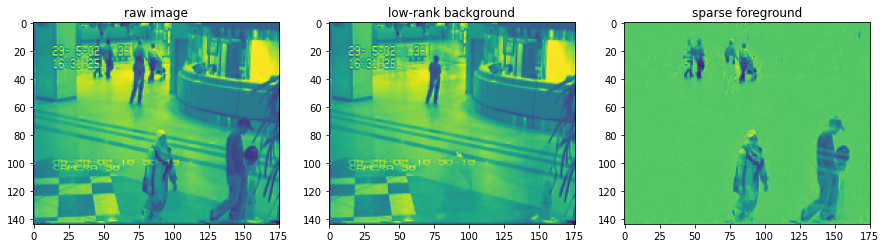

In [102]:
idx = 20

fig, axs = plt.subplots(1, 3, figsize=(15, 15))

# raw image
a = D[idx]
a = a.reshape((p, q))
axs[0].imshow(a)
axs[0].set_title('raw image')

# low-rank background
b = L[idx]
b = b.reshape((p, q))
axs[1].imshow(b)
axs[1].set_title('low-rank background')

# sparse foreground
c = S[idx]
c = c.reshape((p, q))
axs[2].imshow(c)
axs[2].set_title('sparse foreground')

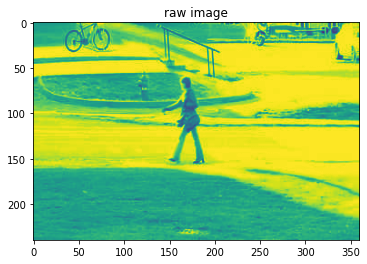

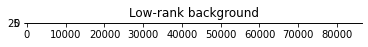

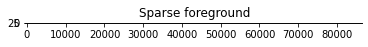

In [25]:
plt.imshow(raw_img)
plt.title("raw image")
plt.show()

plt.imshow(L)
plt.title("Low-rank background")
plt.show()

plt.imshow(S)
plt.title("Sparse foreground")
plt.show()